In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
def read_csv(path):
    df = pd.read_csv(path)
    df = df.fillna("none")
    return df

# Data Exploration

In [3]:
train_path = "discordbot/data/discord_moderation_train_dataset.csv"
test_path = "discordbot/data/discord_moderation_test_dataset.csv"

df_train = read_csv(train_path)
df_test = read_csv(test_path)

In [4]:
df_train.head()

,message,abuse_type,fraud_subtype
0,"Hey everyone, this is @CodeMaster here. I just...",fraud,impersonation
1,@everyone I'm stuck on level 5 of the game! Ca...,spam,none
2,@everyone HELP! I need info on how to tune my ...,spam,none
3,"Hey guys, just found this sick website where y...",spam,none
4,Hey everyone! I'm trying to decide what to coo...,none,none


In [5]:
# Show examples
idx = 16
row = df_train.iloc[idx]
print("-"*50)
print(row["message"])
print("-"*50)
print(row["abuse_type"])
print(row["fraud_subtype"])

--------------------------------------------------
Guys, have you seen the latest meme about the new Marvel movie? It’s going viral and I can’t find it anywhere! Someone please link it if you’ve got it!
--------------------------------------------------
none
none


# Evaluations

In [6]:
# train set
base_path = "discordbot/data/confusion_data_base_2025-06-01_05-04-21.csv"
optimized_path = "discordbot/data/confusion_data_optimized_2025-06-01_04-59-34.csv"

# # dev set
# base_path = "discordbot/data/confusion_data_base_2025-06-01_16-03-27.csv"
# optimized_path = "discordbot/data/confusion_data_optimized_2025-06-01_16-02-39.csv"

In [7]:
df = read_csv(optimized_path)
df.head()

,message,actual_abuse_type,predicted_abuse_type,actual_fraud_subtype,predicted_fraud_subtype,predicted_severity,predicted_reason,predicted_confidence
0,Hey everyone! 🌟 I just started learning Python...,none,none,none,none,low,The message is a friendly request for help and...,0.95
1,Hey everyone! I'm trying to decide what to coo...,none,none,none,none,low,The message is a harmless request for suggesti...,0.95
2,"@ProjectNewbie Your code is so bad, I don't ev...",harassment,harassment,none,none,medium,The message is disrespectful and belittles ano...,0.85
3,"Hey everyone, I'm looking to upgrade my gaming...",none,none,none,none,low,The message is a legitimate inquiry for help r...,0.95
4,Hey everyone! Just got tickets to see The Chai...,none,none,none,none,low,The message is a positive expression about att...,0.95


# Precision and Recall

In [8]:
def binarize_and_balance(df):
    # Convert to binary classification - any abuse type is considered abuse
    actual_binary = df['actual_abuse_type'].apply(lambda x: 'abuse' if x != 'none' else 'none')
    
    # Perform stratified sampling to balance classes
    abuse_samples = df[actual_binary == 'abuse']
    non_abuse_samples = df[actual_binary == 'none']
    
    # Sample equal number of abuse and non-abuse examples
    min_samples = min(len(abuse_samples), len(non_abuse_samples))
    balanced_df = pd.concat([
        abuse_samples.sample(min_samples),
        non_abuse_samples.sample(min_samples)
    ])
    
    # Recalculate binary labels for balanced dataset
    actual_binary = balanced_df['actual_abuse_type'].apply(lambda x: 'abuse' if x != 'none' else 'none')
    predicted_binary = balanced_df['predicted_abuse_type'].apply(lambda x: 'abuse' if x != 'none' else 'none')
    
    return balanced_df, actual_binary, predicted_binary

In [9]:
# Compute binary precision and recall for abuse vs non-abuse
def compute_binary_metrics(df):
    
    balanced_df, actual_binary, predicted_binary = binarize_and_balance(df)
    
    # Print counts for each class
    print(f"Total samples: {len(balanced_df)}")
    print(f"    Abuse samples: {len(actual_binary[actual_binary == 'abuse'])}")
    print(f"    Non-abuse samples: {len(actual_binary[actual_binary == 'none'])}")
    
    # Print predicted counts
    print(f"    Predicted abuse samples: {len(predicted_binary[predicted_binary == 'abuse'])}")
    print(f"    Predicted non-abuse samples: {len(predicted_binary[predicted_binary == 'none'])}")
    
    # Calculate confusion matrix
    cm = confusion_matrix(actual_binary, predicted_binary, labels=['none', 'abuse'])
    
    # Extract values
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\nBinary Classification Metrics:")
    print(f"    Precision: {precision:.3f}")
    print(f"    Recall: {recall:.3f}")
    print(f"    F1 Score: {f1:.3f}")
    
    print("\nConfusion Matrix:")
    print(f"    True Negatives: {tn}")
    print(f"    False Positives: {fp}")
    print(f"    False Negatives: {fn}")
    print(f"    True Positives: {tp}")
    
    # Return false positives and false negatives for further analysis
    fp_df = balanced_df[(actual_binary == 'none') & (predicted_binary == 'abuse')]
    fn_df = balanced_df[(actual_binary == 'abuse') & (predicted_binary == 'none')]
    
    return fp_df, fn_df

In this binary classification:
- Positive class: 'abuse' (any type of abuse)
- Negative class: 'none' (no abuse)

Confusion matrix interpretation:
- True Negatives (TN): Correctly identified non-abusive messages
- False Positives (FP): Non-abusive messages incorrectly flagged as abuse
- False Negatives (FN): Abusive messages incorrectly classified as non-abuse
- True Positives (TP): Correctly identified abusive messages

Metric Interpretations:
- Precision: Of all messages flagged as abuse, what percentage were actually abusive
	- Higher precision means fewer false alarms (false positives)
- Recall: Of all actual abusive messages, what percentage were correctly identified
	- Higher recall means fewer abusive messages missed (false negatives)
- F1 Score: Harmonic mean of precision and recall
	- Balances the trade-off between precision and recall
	- Higher F1 means better overall performance

In [10]:
# Compute metrics for both base and optimized models
print("Base Model Metrics:")
fp_base, fn_base = compute_binary_metrics(read_csv(base_path))

Base Model Metrics:
Total samples: 774
    Abuse samples: 387
    Non-abuse samples: 387
    Predicted abuse samples: 306
    Predicted non-abuse samples: 468

Binary Classification Metrics:
    Precision: 0.984
    Recall: 0.778
    F1 Score: 0.869

Confusion Matrix:
    True Negatives: 382
    False Positives: 5
    False Negatives: 86
    True Positives: 301


In [11]:
print("Optimized Model Metrics:")
fp_optimized, fn_optimized = compute_binary_metrics(read_csv(optimized_path))

Optimized Model Metrics:
Total samples: 774
    Abuse samples: 387
    Non-abuse samples: 387
    Predicted abuse samples: 347
    Predicted non-abuse samples: 427

Binary Classification Metrics:
    Precision: 0.965
    Recall: 0.866
    F1 Score: 0.913

Confusion Matrix:
    True Negatives: 375
    False Positives: 12
    False Negatives: 52
    True Positives: 335


In [12]:
# Sample false positives and false negatives for analysis
print("\nSample False Positives (Optimized Model):")
fp_samples = fp_optimized.sample(min(5, len(fp_optimized)))
for idx, row in fp_samples.iterrows():
    print("\nMessage:", row['message'])
    print("Actual Type:", row['actual_abuse_type'])
    print("Predicted Type:", row['predicted_abuse_type'])
    print("-" * 80)


Sample False Positives (Optimized Model):

Message: Hey everyone! 🎉 I just found this hilarious meme and I had to share it with you all! 😂 It’s perfect for our channel. Check it out! #MemeLords #FunTimes
Actual Type: none
Predicted Type: spam
--------------------------------------------------------------------------------

Message: Hey everyone! Just heard some amazing news about Solana! 🚀 It’s been on fire lately, and I think it's a great time to hop on board. Who else is as hyped as I am? #SolanaBullRun 💥
Actual Type: none
Predicted Type: inappropriate
--------------------------------------------------------------------------------

Message: 🚨 Attention all crypto investors! 🚨 The market is showing strong signals for a surge in ETH. I just placed my buy order and I’m expecting a solid 10% gain by the end of the week. If you’re on the fence, now’s the time to act! 🔥 #HODL
Actual Type: none
Predicted Type: fraud
-------------------------------------------------------------------------

In [13]:
print("\nSample False Negatives (Optimized Model):")
fn_samples = fn_optimized.sample(min(5, len(fn_optimized)))
for idx, row in fn_samples.iterrows():
    print("\nMessage:", row['message'])
    print("Actual Type:", row['actual_abuse_type'])
    print("Predicted Type:", row['predicted_abuse_type'])
    print("-" * 80)



Sample False Negatives (Optimized Model):

Message: Hey everyone! Just a quick tip for managing risks in trades. Always make sure you're comfortable with the terms and never trade more than you're willing to lose. It's like they say, "If it feels too good to be true, it probably is." But hey, if you ever need some extra motivation, just remember to keep things light and fun! 😜🚀
Actual Type: inappropriate
Predicted Type: none
--------------------------------------------------------------------------------

Message: Hey everyone! I just got my new graphics card and it's so powerful, it's like a beast on steroids! 🚀 But I think I might have fried it when I tried to overclock it. Can anyone help me figure out if it's still alive? Also, does anyone else find it a bit funny how we refer to our GPUs as "girls" sometimes? Haha, just a little tech humor! 😂
Actual Type: inappropriate
Predicted Type: none
--------------------------------------------------------------------------------

Message: 

Generating classification metrics for optimized model...


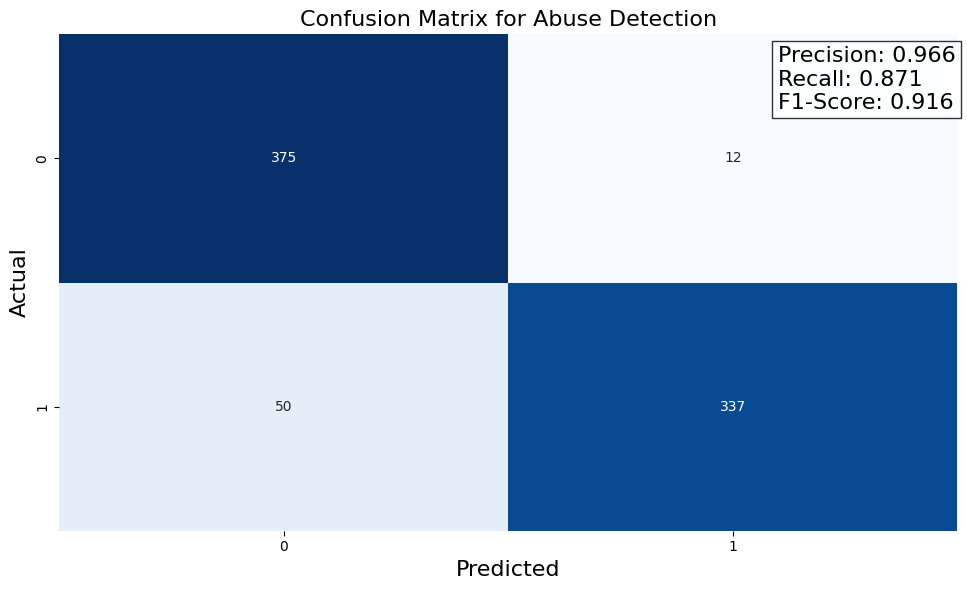

In [14]:
from sklearn.metrics import confusion_matrix, classification_report

def plot_classification_metrics(csv_path):
    """
    Generate and plot classification metrics for the model predictions.
    
    Args:
        csv_path (str): Path to the CSV file containing model predictions
    """
    # Read the CSV file
    balanced_df, actual_binary, predicted_binary = binarize_and_balance(read_csv(csv_path))
    
    # Convert abuse types to binary (abuse vs non-abuse)
    y_true = (actual_binary != 'none').astype(int)
    y_pred = (predicted_binary != 'none').astype(int)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate classification metrics
    report = classification_report(y_true, y_pred, output_dict=True)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('Actual', fontsize=16)
    plt.title('Confusion Matrix for Abuse Detection', fontsize=16)
    
    # Add metrics text
    metrics_text = f"Precision: {report['1']['precision']:.3f}\n"
    metrics_text += f"Recall: {report['1']['recall']:.3f}\n"
    metrics_text += f"F1-Score: {report['1']['f1-score']:.3f}"
    
    plt.text(1.6, 0.3, metrics_text, fontsize=16, 
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return report

# Generate classification metrics for optimized model
print("Generating classification metrics for optimized model...")
metrics = plot_classification_metrics(optimized_path)

# Confusion Matrix

In [15]:
# dev set
# base_path = "discordbot/data/confusion_data_base_2025-06-01_16-03-27.csv"
# optimized_path = "discordbot/data/confusion_data_optimized_2025-06-01_16-02-39.csv"

In [16]:
def plot_confusion_matrices(csv_path):
    """
    Create a paired plot showing confusion matrices for abuse type and fraud subtype.
    For fraud subtypes, only includes examples where abuse type was correctly predicted as fraud.
    
    Args:
        csv_path (str): Path to the CSV file containing confusion data
    """
    # Read the CSV file
    df = read_csv(csv_path)
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Get unique classes for abuse types and fraud subtypes
    abuse_classes = sorted(df['actual_abuse_type'].unique())
    
    # Create confusion matrices
    abuse_cm = confusion_matrix(df['actual_abuse_type'], df['predicted_abuse_type'], labels=abuse_classes)
    
    # For fraud subtypes, only include examples where abuse type was correctly predicted as fraud
    fraud_df = df[(df['actual_abuse_type'] == 'fraud') & (df['predicted_abuse_type'] == 'fraud')]
    fraud_classes = sorted(fraud_df['actual_fraud_subtype'].unique())
    fraud_cm = confusion_matrix(fraud_df['actual_fraud_subtype'], fraud_df['predicted_fraud_subtype'], labels=fraud_classes)

    
    # Calculate accuracies
    abuse_accuracy = np.sum(np.diag(abuse_cm)) / np.sum(abuse_cm)
    fraud_accuracy = np.sum(np.diag(fraud_cm)) / np.sum(fraud_cm)
    
    # Plot abuse type confusion matrix
    sns.heatmap(abuse_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=abuse_classes, yticklabels=abuse_classes, ax=ax1, cbar=False)
    ax1.set_xlabel('Predicted Abuse Type')
    ax1.set_ylabel('Actual Abuse Type')
    ax1.set_title(f'Abuse Type Confusion Matrix\nAccuracy: {abuse_accuracy:.2%}')
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot fraud subtype confusion matrix
    sns.heatmap(fraud_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=fraud_classes, yticklabels=fraud_classes, ax=ax2, cbar=False)
    ax2.set_xlabel('Predicted Fraud Subtype')
    ax2.set_ylabel('Actual Fraud Subtype')
    ax2.set_title(f'Fraud Subtype Confusion Matrix\nAccuracy: {fraud_accuracy:.2%}\n(Only when abuse type is correctly predicted as fraud)')
    ax2.tick_params(axis='x', rotation=45)
    
    # Print accuracies
    print(f"Abuse Type Accuracy: {abuse_accuracy:.2%}")
    print(f"Fraud Subtype Accuracy: {fraud_accuracy:.2%} (only when abuse type is correctly predicted as fraud)")
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()

Abuse Type Accuracy: 67.38%
Fraud Subtype Accuracy: 67.74% (only when abuse type is correctly predicted as fraud)


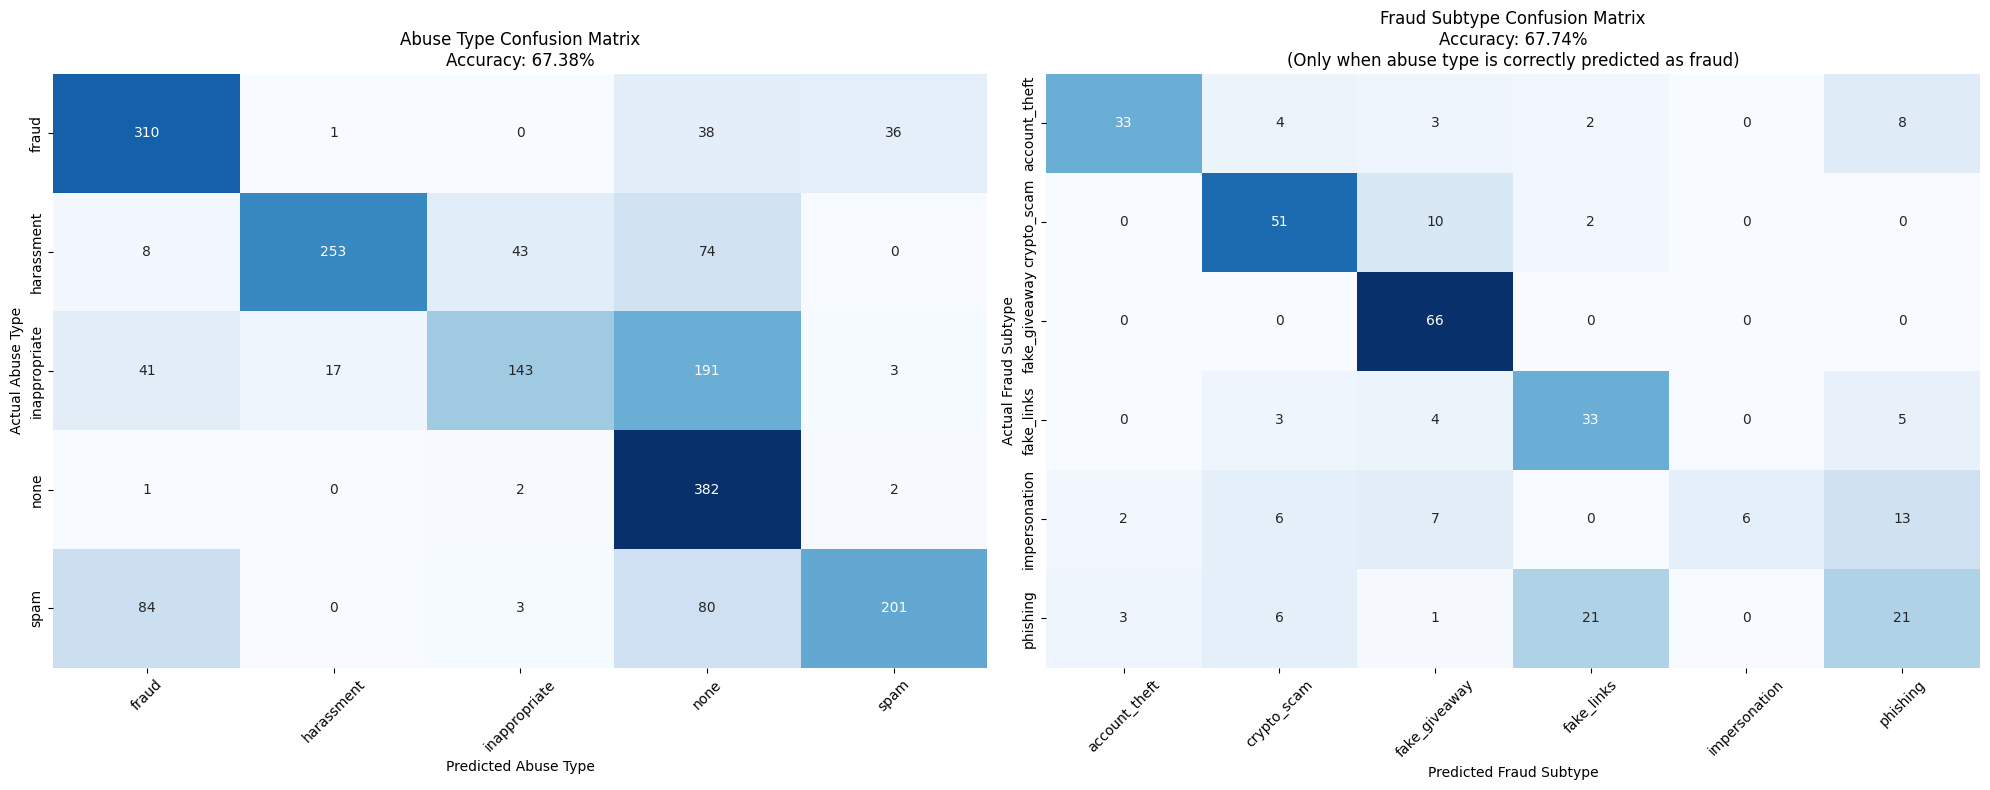

In [17]:
plot_confusion_matrices(base_path)

Abuse Type Accuracy: 74.44%
Fraud Subtype Accuracy: 68.93% (only when abuse type is correctly predicted as fraud)


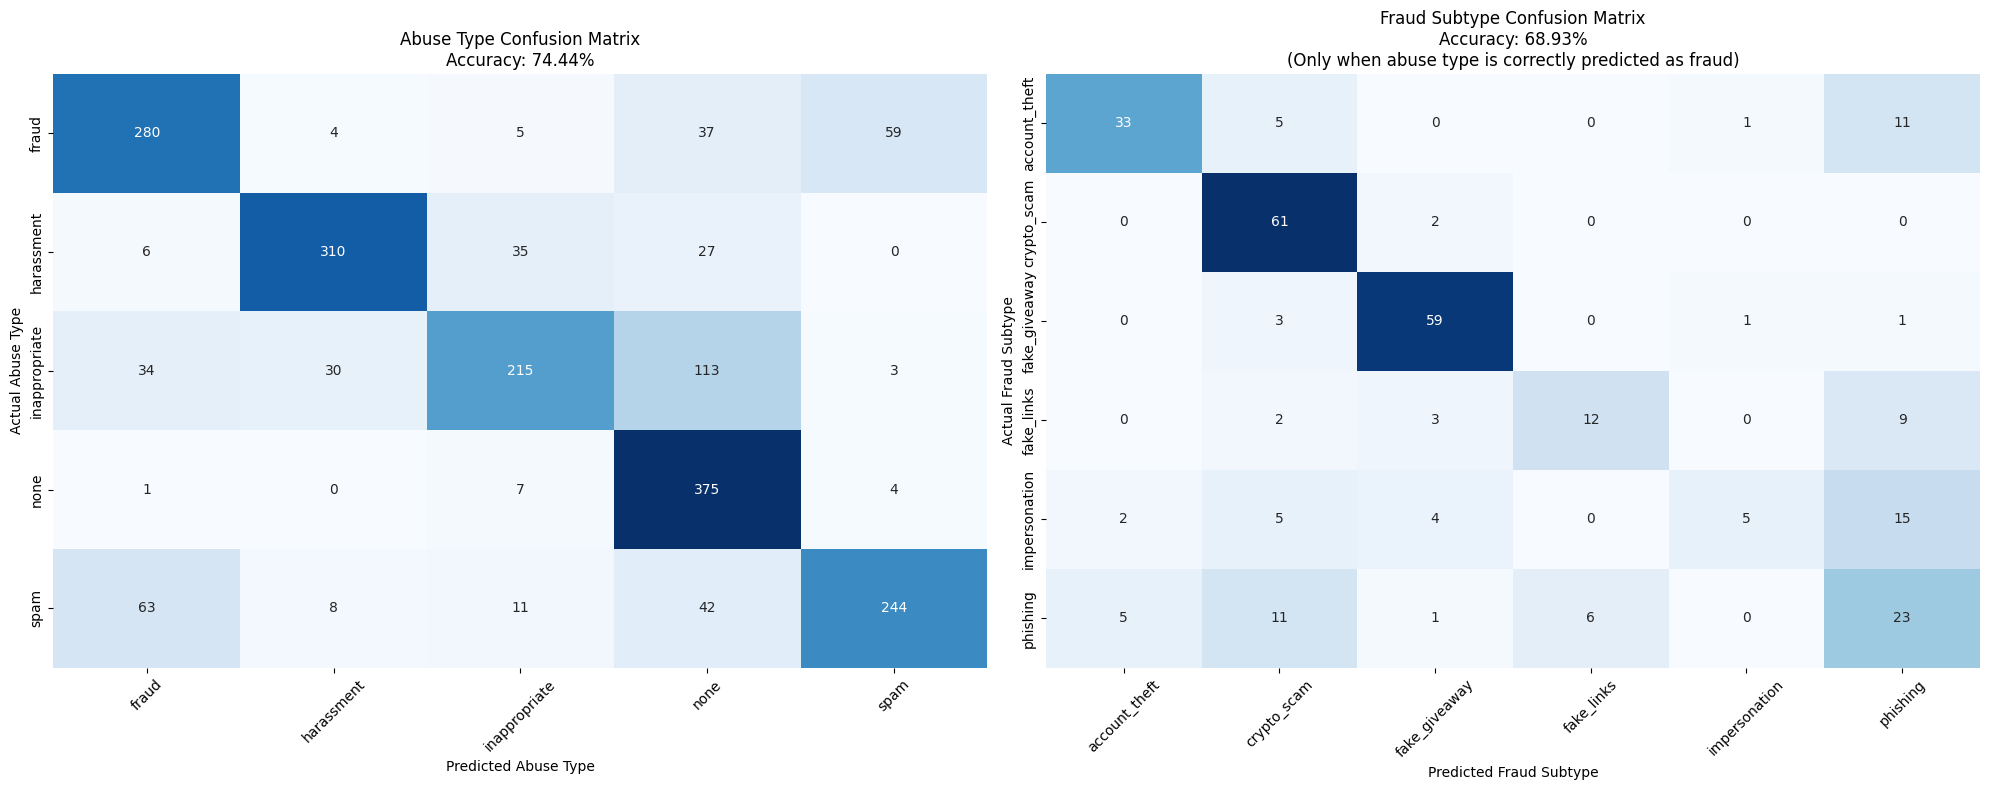

In [18]:
plot_confusion_matrices(optimized_path)

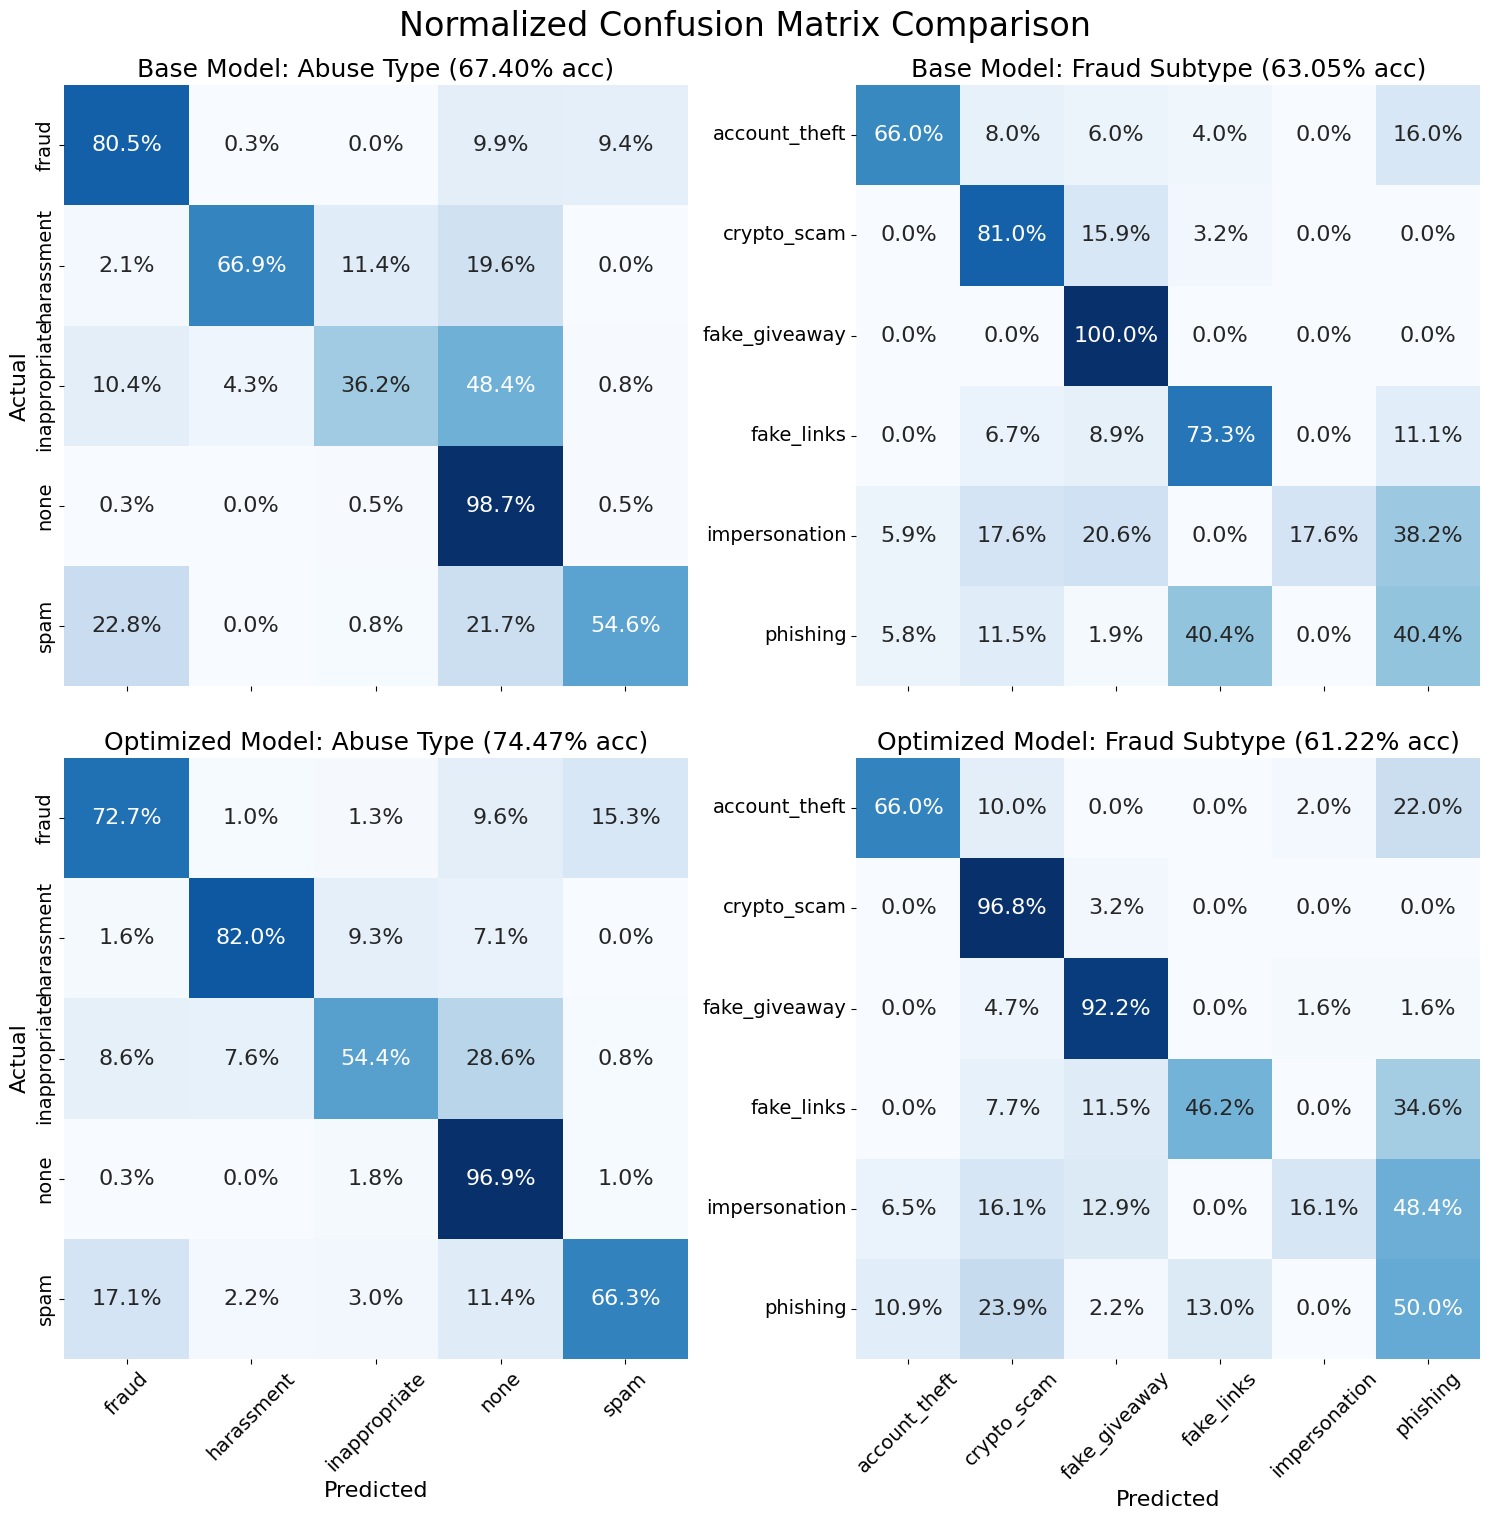

In [41]:
def plot_comparison_confusion_matrices(base_path, optimized_path):
    # Read data
    base_df = read_csv(base_path)
    optimized_df = read_csv(optimized_path)
    
    # Create figure with 2x2 subplots, sharing axes between rows
    fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex='col', sharey='col')
    fig.suptitle('Normalized Confusion Matrix Comparison', fontsize=24, y=0.99)
    
    # Add spacing between rows by adjusting figure height and position
    fig.set_figheight(15)  # Increase figure height
    fig.subplots_adjust(top=0.85)  # Adjust top margin for suptitle
    
    # Process base model data
    base_abuse_classes = sorted(base_df['actual_abuse_type'].unique())
    base_abuse_cm = confusion_matrix(base_df['actual_abuse_type'], 
                                    base_df['predicted_abuse_type'], 
                                    labels=base_abuse_classes)
    # Normalize confusion matrix
    base_abuse_cm = base_abuse_cm.astype('float') / base_abuse_cm.sum(axis=1)[:, np.newaxis]
    
    base_fraud_df = base_df[(base_df['actual_abuse_type'] == 'fraud') & 
                           (base_df['predicted_abuse_type'] == 'fraud')]
    base_fraud_classes = sorted(base_fraud_df['actual_fraud_subtype'].unique())
    base_fraud_cm = confusion_matrix(base_fraud_df['actual_fraud_subtype'], 
                                    base_fraud_df['predicted_fraud_subtype'], 
                                    labels=base_fraud_classes)
    # Normalize confusion matrix
    base_fraud_cm = base_fraud_cm.astype('float') / base_fraud_cm.sum(axis=1)[:, np.newaxis]
    
    # Process optimized model data
    opt_abuse_classes = sorted(optimized_df['actual_abuse_type'].unique())
    opt_abuse_cm = confusion_matrix(optimized_df['actual_abuse_type'], 
                                   optimized_df['predicted_abuse_type'], 
                                   labels=opt_abuse_classes)
    # Normalize confusion matrix
    opt_abuse_cm = opt_abuse_cm.astype('float') / opt_abuse_cm.sum(axis=1)[:, np.newaxis]
    
    opt_fraud_df = optimized_df[(optimized_df['actual_abuse_type'] == 'fraud') & 
                               (optimized_df['predicted_abuse_type'] == 'fraud')]
    opt_fraud_classes = sorted(opt_fraud_df['actual_fraud_subtype'].unique())
    opt_fraud_cm = confusion_matrix(opt_fraud_df['actual_fraud_subtype'], 
                                   opt_fraud_df['predicted_fraud_subtype'], 
                                   labels=opt_fraud_classes)
    # Normalize confusion matrix
    opt_fraud_cm = opt_fraud_cm.astype('float') / opt_fraud_cm.sum(axis=1)[:, np.newaxis]
    
    # Calculate accuracies
    base_abuse_acc = np.sum(np.diag(base_abuse_cm)) / len(base_abuse_cm)
    base_fraud_acc = np.sum(np.diag(base_fraud_cm)) / len(base_fraud_cm)
    opt_abuse_acc = np.sum(np.diag(opt_abuse_cm)) / len(opt_abuse_cm)
    opt_fraud_acc = np.sum(np.diag(opt_fraud_cm)) / len(opt_fraud_cm)
    
    # Plot base model confusion matrices
    sns.heatmap(base_abuse_cm, annot=True, fmt='.1%', cmap='Blues',
                xticklabels=base_abuse_classes, yticklabels=base_abuse_classes,
                ax=axes[0,0], cbar=False, annot_kws={'size': 16})
    axes[0,0].set_ylabel('Actual', fontsize=16)
    axes[0,0].set_title(f'Base Model: Abuse Type ({base_abuse_acc:.2%} acc)', fontsize=18)
    axes[0,0].tick_params(axis='both', labelsize=14)
    
    sns.heatmap(base_fraud_cm, annot=True, fmt='.1%', cmap='Blues',
                xticklabels=base_fraud_classes, yticklabels=base_fraud_classes,
                ax=axes[0,1], cbar=False, annot_kws={'size': 16})
    axes[0,1].set_title(f'Base Model: Fraud Subtype ({base_fraud_acc:.2%} acc)', fontsize=18)
    axes[0,1].tick_params(axis='both', labelsize=14)
    
    # Plot optimized model confusion matrices
    sns.heatmap(opt_abuse_cm, annot=True, fmt='.1%', cmap='Blues',
                xticklabels=opt_abuse_classes, yticklabels=opt_abuse_classes,
                ax=axes[1,0], cbar=False, annot_kws={'size': 16})
    axes[1,0].set_xlabel('Predicted', fontsize=16)
    axes[1,0].set_ylabel('Actual', fontsize=16)
    axes[1,0].set_title(f'Optimized Model: Abuse Type ({opt_abuse_acc:.2%} acc)', fontsize=18)
    axes[1,0].tick_params(axis='both', labelsize=14)
    
    sns.heatmap(opt_fraud_cm, annot=True, fmt='.1%', cmap='Blues',
                xticklabels=opt_fraud_classes, yticklabels=opt_fraud_classes,
                ax=axes[1,1], cbar=False, annot_kws={'size': 16})
    axes[1,1].set_xlabel('Predicted', fontsize=16)
    axes[1,1].set_title(f'Optimized Model: Fraud Subtype ({opt_fraud_acc:.2%} acc)', fontsize=18)
    axes[1,1].tick_params(axis='both', labelsize=14)
    
    # Rotate x-axis labels for better readability
    for ax in axes.flat:
        ax.tick_params(axis='x', rotation=45)
    
    # Adjust layout with more space between rows
    plt.tight_layout()
    
    # Add extra space between rows by adjusting subplot positions
    for ax in axes[1]:
        pos = ax.get_position()
        ax.set_position([pos.x0, pos.y0 - 0.02, pos.width, pos.height])
    
    # Show plot
    plt.show()

# Call the function with the paths
plot_comparison_confusion_matrices(base_path, optimized_path)


In [20]:
def print_abuse_type_misclassifications(df, n=3):
    # Get abuse type misclassifications
    abuse_misclass = df[df['actual_abuse_type'] != df['predicted_abuse_type']]
    print("\n=== Abuse Type Misclassifications ===")
    for _, row in abuse_misclass.head(n).iterrows():
        print(f"\nMessage: {row['message']}")
        print(f"Actual: {row['actual_abuse_type']}")
        print(f"Predicted: {row['predicted_abuse_type']}")
        print(f"Confidence: {row['predicted_confidence']:.2f}")
        
def print_fraud_subtype_misclassifications(df, n=3):
    # Get fraud subtype misclassifications
    fraud_misclass = df[(df['actual_abuse_type'] == 'fraud') & 
                       (df['predicted_abuse_type'] == 'fraud') &
                       (df['actual_fraud_subtype'] != df['predicted_fraud_subtype'])]
    
    print("\n=== Fraud Subtype Misclassifications ===")
    for _, row in fraud_misclass.head(n).iterrows():
        print(f"\nMessage: {row['message']}")
        print(f"Actual: {row['actual_fraud_subtype']}")
        print(f"Predicted: {row['predicted_fraud_subtype']}")
        print(f"Confidence: {row['predicted_confidence']:.2f}")

In [21]:
print("=== Optimized Model Misclassifications ===")
optimized_df = read_csv(optimized_path)

=== Optimized Model Misclassifications ===


In [22]:
print_abuse_type_misclassifications(optimized_df)


=== Abuse Type Misclassifications ===

Message: Hey everyone, this is @CodeMaster here. I just got a new laptop and I'm setting up my environment. Could someone please review this function I wrote? I want to make sure it's secure and follows our best practices. Also, could you share any tips on how to avoid common pitfalls? Thanks!

```python
def process_data(data):
    # Some sensitive operations
    return data
```
Actual: fraud
Predicted: none
Confidence: 0.95

Message: Hey @CodeNewbie, I see you're struggling with those algorithms. Don't worry, I can totally help you out! But first, why don't you tell me more about yourself? Maybe we can grab a coffee sometime and chat about coding in person. 😄
Actual: harassment
Predicted: inappropriate
Confidence: 0.70

Message: @everyone I'm stuck on level 5 of the game! Can someone PLEASE help me? I've been trying for hours and can't figure it out. Anyone?? HELP!!! #stuck #needhelp
Actual: spam
Predicted: none
Confidence: 0.95


In [23]:
print_fraud_subtype_misclassifications(optimized_df)


=== Fraud Subtype Misclassifications ===

Message: Hey everyone, this is Alex from Tech Support. We've identified a critical bug affecting the tutorials section of our platform. To resolve this, I need a few volunteers to grant me temporary admin access to their accounts. This will allow me to test and fix the issue faster. Please DM me your login details ASAP. Thank you for your help!
Actual: impersonation
Predicted: phishing
Confidence: 0.95

Message: I can't believe I'm still struggling to find a decent job in this field! I mean, look at this offer I found. It seems legit, right? They're offering a great position for remote software developers. Anyone interested? 🤞 [FakeLinkRemovedForSafety]
Actual: fake_links
Predicted: phishing
Confidence: 0.85

Message: Hey there! I noticed you might need some help setting up your new software. I’m from the Tech Support team, and I can guide you through it. Just shoot me a DM with your login details, and we’ll get you all set up in no time!
Actu

In [24]:
print("\n=== Base Model Misclassifications ===")
base_df = read_csv(base_path)


=== Base Model Misclassifications ===


In [25]:
print_abuse_type_misclassifications(base_df)


=== Abuse Type Misclassifications ===

Message: @everyone I'm stuck on level 5 of the game! Can someone PLEASE help me? I've been trying for hours and can't figure it out. Anyone?? HELP!!! #stuck #needhelp
Actual: spam
Predicted: none
Confidence: 0.95

Message: Hey everyone, this is @CodeMaster here. I just got a new laptop and I'm setting up my environment. Could someone please review this function I wrote? I want to make sure it's secure and follows our best practices. Also, could you share any tips on how to avoid common pitfalls? Thanks!

```python
def process_data(data):
    # Some sensitive operations
    return data
```
Actual: fraud
Predicted: none
Confidence: 0.95

Message: Hey @CodeNewbie, I see you're struggling with those algorithms. Don't worry, I can totally help you out! But first, why don't you tell me more about yourself? Maybe we can grab a coffee sometime and chat about coding in person. 😄
Actual: harassment
Predicted: none
Confidence: 0.70


In [26]:
print_fraud_subtype_misclassifications(base_df)


=== Fraud Subtype Misclassifications ===

Message: Hey everyone, this is Alex from Tech Support. We've identified a critical bug affecting the tutorials section of our platform. To resolve this, I need a few volunteers to grant me temporary admin access to their accounts. This will allow me to test and fix the issue faster. Please DM me your login details ASAP. Thank you for your help!
Actual: impersonation
Predicted: phishing
Confidence: 0.95

Message: Hey there! I noticed you might need some help setting up your new software. I’m from the Tech Support team, and I can guide you through it. Just shoot me a DM with your login details, and we’ll get you all set up in no time!
Actual: impersonation
Predicted: phishing
Confidence: 0.95

Message: Hey everyone, this is @CryptoWhale speaking. I've got inside info that ETH is going to moon tonight! Load up your wallets and get ready to cash out big. Trust me, you don't want to miss this one. #HODL
Actual: impersonation
Predicted: crypto_scam
